In [1]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn


%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df
from src.utils.variant_utils import get_high, get_low
from icecream import ic
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df

0.5.6


In [2]:
samples = ["Control","Flt3l"]


In [3]:
INDIR = "/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex"
cells_meta_f = "/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/cells_meta.tsv"
OUTDIR = "/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/clones_qc/"
col = "lineage"
filt_col = "donor"
filt_val = 0


# Params
vars_to_plot=10
sample_names="Control,Flt3l"
N_DONORS=4

In [4]:
cells_meta = pd.read_csv(cells_meta_f, sep='\t')
cells_meta = cells_meta.astype({"donor_index": "Int64", "donor": "Int64", "lineage":"Int64", "lineage_index":"Int64"})
cells_meta = cells_meta.set_index("ID")
cells_meta
#cells_meta.head()

,Unnamed: 0,level_0,index,raw ID,new index,condition,donor,donor_index,lineage,lineage_index
ID,,,,,,,,,,
AAACGAAAGTCGTGAG-1_Control,0,2,2,AAACGAAAGTCGTGAG-1,3,Control,0,1,<NA>,<NA>
AAACGAACACAATAAG-1_Control,1,4,4,AAACGAACACAATAAG-1,5,Control,0,2,<NA>,<NA>
AAACGAAGTAAGTCTC-1_Control,2,9,9,AAACGAAGTAAGTCTC-1,10,Control,0,3,<NA>,<NA>
AAACGAAGTGGATTCT-1_Control,3,12,12,AAACGAAGTGGATTCT-1,13,Control,0,4,<NA>,<NA>
AAACGAATCGCAACTA-1_Control,4,14,14,AAACGAATCGCAACTA-1,15,Control,0,5,3,1
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTTAACCAC-1_Flt3l,3746,17371,17371,TTTGGTTGTTAACCAC-1,17372,Flt3l,3,3747,18,174
TTTGTGTAGAGAGTAG-1_Flt3l,3747,17378,17378,TTTGTGTAGAGAGTAG-1,17379,Flt3l,3,3748,<NA>,<NA>
TTTGTGTGTATTCTGG-1_Flt3l,3748,17394,17394,TTTGTGTGTATTCTGG-1,17395,Flt3l,3,3749,<NA>,<NA>


In [5]:
vcf_f = join(INDIR, f"{filt_col}{filt_val}.vcf")
vcf= pd.read_csv(vcf_f,
                sep='\t').fillna("N")
vcf.index = vcf.apply(lambda x: x["REF"] + ">" + x["ALT"],axis=1)
vcf.head()

,#CHROM,POS,REF,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,index,old /data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/Control/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/Control/vireoIn,strand_correlation_y,vmr_y,n_cells_over_5_y,n_cells_over_20_y,old /data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/Flt3l/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/Flt3l/vireoIn,new ID
49A>G,chrM,49,49A,G,0.905935,0.042452,18.0,0.0,49A>G,1.0,0.83362,0.04046,51.0,0.0,1.0,1
64C>T,chrM,64,64C,T,0.986767,0.685692,1639.0,1527.0,64C>T,2.0,0.982849,0.57238,4015.0,3670.0,2.0,2
73A>C,chrM,73,73A,C,1.0,0.0679,3.0,0.0,73A>C,3.0,1.0,0.030665,3.0,0.0,3.0,3
73A>G,chrM,73,73A,G,0.988898,0.233772,4897.0,4799.0,73A>G,4.0,0.985724,0.157778,9817.0,9564.0,4.0,4
78C>T,chrM,78,78C,T,0.974539,0.039218,7.0,0.0,78C>T,5.0,N,N,N,N,N,5


In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep="\t")
curr_cells_meta = cells_meta[cells_meta[filt_col] == filt_val].sort_values("donor_index").set_index("ID")

In [7]:
af, dp = wrap_load_mtx_df(INDIR, oth_f=False, prefix=f"{filt_col}{filt_val}",
                     columns=('Variant', 'Cell', 'integer'), inc_af=True,
                     as_dense=True, var_names=False, vcf_prefix=f"{filt_col}{filt_val}",
                     verbose=True, cell_names=False)

af.index=vcf.index
dp.index=vcf.index


af.columns = curr_cells_meta.index
dp.columns = curr_cells_meta.index

ic| prefix: 'donor0'


In [8]:
af

ID,AAACGAAAGTCGTGAG-1_Control,AAACGAACACAATAAG-1_Control,AAACGAAGTAAGTCTC-1_Control,AAACGAAGTGGATTCT-1_Control,AAACGAATCGCAACTA-1_Control,AAACTCGCAAGACTTC-1_Control,AAACTCGCATCGCCTT-1_Control,AAACTCGGTATCCTTT-1_Control,AAACTCGTCGAGTGTT-1_Control,AAACTGCAGGGACGTT-1_Control,...,TTTGGTTTCCTAGAGT-1_Flt3l,TTTGTGTAGAGAACCC-1_Flt3l,TTTGTGTAGAGGTCCA-1_Flt3l,TTTGTGTAGCGTCAAG-1_Flt3l,TTTGTGTAGGAGTCTG-1_Flt3l,TTTGTGTCACGCCGAT-1_Flt3l,TTTGTGTCACTACACA-1_Flt3l,TTTGTGTGTATACGCT-1_Flt3l,TTTGTGTGTATCTCAG-1_Flt3l,TTTGTGTTCGAGTTAC-1_Flt3l
49A>G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.019231,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
64C>T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
73A>C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
73A>G,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.913043,1.000000,1.0,...,1.0,1.0,0.999999,1.000000,1.0,0.999999,1.0,1.0,1.0,1.0
78C>T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15791A>G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.027027,0.0,0.000000,0.0,0.0,0.0,0.0
16131T>C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
16362T>A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
16525A>G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [9]:
def calc_fold(af):
    variant_df = vu.type_of_variants(af.index)

    variants_box= vu.variants_dense(af, vars_to_plot, samples_d=curr_cells_meta['condition'], donors_d=curr_cells_meta['donor'],
                                  variant_d=variant_df['variant type'])
    variants_box


    fold_vars = {}
    mean_vars = {}
    for ind, val in variants_box.groupby("Variant"):
        cond_means = (val.groupby("condition").mean())[["sqrtAF"]]
        mean_vars[ind] = cond_means.values.flatten()

        cond_fold = cond_means.loc[samples[1]]/cond_means.loc[samples[0]]
        fold_vars[ind] = cond_fold


    fold_vars = pd.DataFrame(fold_vars)

    len(variants_box["Variant"].unique())

    mean_vars_df = pd.DataFrame(mean_vars, index=samples)
    mean_vars_df = mean_vars_df.reset_index().rename({"index":"condition"}, axis=1).melt(id_vars="condition")
    
    
    return pd.DataFrame(fold_vars), mean_vars_df

In [10]:
fold_vars, mean_vars_df = calc_fold(af)

In [11]:
mean_vars_df

,condition,variable,value
0,Control,11719G>A,0.996217
1,Flt3l,11719G>A,0.996584
2,Control,1438A>G,0.997933
3,Flt3l,1438A>G,0.996822
4,Control,14766C>T,0.996508
5,Flt3l,14766C>T,0.996779
6,Control,15326A>G,0.996971
7,Flt3l,15326A>G,0.996799
8,Control,16223C>T,0.997934
9,Flt3l,16223C>T,0.997800


In [12]:
mean_vars_df

,condition,variable,value
0,Control,11719G>A,0.996217
1,Flt3l,11719G>A,0.996584
2,Control,1438A>G,0.997933
3,Flt3l,1438A>G,0.996822
4,Control,14766C>T,0.996508
5,Flt3l,14766C>T,0.996779
6,Control,15326A>G,0.996971
7,Flt3l,15326A>G,0.996799
8,Control,16223C>T,0.997934
9,Flt3l,16223C>T,0.997800


var 11719G>A
var 1438A>G
var 14766C>T
var 15326A>G
var 16223C>T
var 263A>G
var 2706A>G
var 73A>G
var 750A>G
var 8860A>G


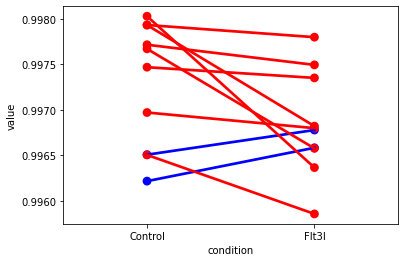

In [13]:
f, ax = plt.subplots()
for var, df in mean_vars_df.groupby("variable"):
    if fold_vars[var].values[0]>1:

        clr = 'b'
    elif fold_vars[var].values[0]<1:
        clr = 'r'
    else: 
        clr = 'b'
    print('var', var)
    
    sns.pointplot(x="condition", y="value", data=df, color = clr, ax=ax)
    

## Shuffle AF in a cell

In [14]:
from copy import deepcopy
from tqdm import tqdm

In [15]:
def single_shuffle_vars(af):
    af = deepcopy(af)
    for i in tqdm(af.columns):
        #print(i)
        af.loc[i] = af.loc[np.random.permutation(af.index),i]
    fold, _ = calc_fold(af)
    print('fold', fold)
    return fold


def shuffle_vars(af,n_sim=1000):
    allAFs = []
    maxAFs = []
    for s in range(n_sim):
        shuf_fold = single_shuffle_vars(af)
        allAFs.append(shuff_fold)
        maxAFs.append(shuff_fold(max))
    return allAFs

100%|███████████████████████████████████████| 4205/4205 [02:59<00:00, 23.47it/s]


In [18]:
shuff_af = single_shuffle_vars(af)    



100%|███████████████████████████████████████| 4205/4205 [02:48<00:00, 24.95it/s]


In [17]:
shuff_af

,TTTGGTTTCCTAGAGT-1_Flt3l,TTTGTGTAGAGAACCC-1_Flt3l,TTTGTGTAGAGGTCCA-1_Flt3l,TTTGTGTAGCGTCAAG-1_Flt3l,TTTGTGTAGGAGTCTG-1_Flt3l,TTTGTGTCACGCCGAT-1_Flt3l,TTTGTGTCACTACACA-1_Flt3l,TTTGTGTGTATACGCT-1_Flt3l,TTTGTGTGTATCTCAG-1_Flt3l,TTTGTGTTCGAGTTAC-1_Flt3l
sqrtAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
